In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import norm

from math import log, sqrt, exp
from scipy import stats  
import numpy as np
import math

In [3]:
def solve_tri(m,F): 
    n=len(F)
    L=np.zeros((n,n))
    R=np.eye(n)
    L[0][0]=m[0][0]
    R[0][1]=m[0][1]/L[0][0]
    for i in range(1,n-1):
        L[i][i-1]=m[i][i-1]
        L[i][i]=m[i][i]-L[i][i-1]*R[i-1][i]
        R[i][i+1]=m[i][i+1]/L[i][i]
    L[n-1][n-2]=m[n-1][n-2]
    L[n-1][n-1]=m[n-1][n-1]-L[n-1][n-2]*R[n-2][n-1]
    
    F[0]=F[0]/L[0][0]
    for i in range(1,n):
        F[i]=(F[i]-F[i-1]*L[i][i-1])/L[i][i]
    X=np.zeros(n)
    X[n-1]=F[n-1]
    for i in range(n-2,-1,-1):
        F[i]=F[i]-X[i+1]*R[i][i+1]
        X[i]=F[i]
    return X
    
def european_put_implicit(r,sigma,S_0,K,T,M,N): #r:期望收益率 sigma:波动率 S_0:股票价格 M:纵向划分 N:横向划分
    dS=3*S_0/M
    dt=T/N
    
    a=lambda j: 0.5*r*j*dt-0.5*sigma*sigma*j*j*dt
    b=lambda j: 1+sigma*sigma*j*j*dt+r*dt
    c=lambda j: -0.5*r*j*dt-0.5*sigma*sigma*j*j*dt
    
    f1=[max(K-i*dS,0) for i in range(M+1)]
    f2=[None for i in range(M+1)]
     
    #构建系数矩阵
    coef=np.zeros((M-1,M-1))
    coef[0][0]=b(1) #j=1的边界条件，因为f(N-1,0)=K
    coef[0][1]=c(1)
    coef[M-2][M-3]=a(M-1) #j=M-1的边界条件，上边界
    coef[M-2][M-2]=b(M-1)
    for j in range(2,M-1):
        coef[j-1][j-2]=a(j)
        coef[j-1][j-1]=b(j)
        coef[j-1][j]=c(j)
        
    for i in range(N-1,-1,-1):
        f2=list(f1) #迭代从右边界出发
        F2=f2[1:-1] #切取j=1,...,M-1
        F2[0]-=K*a(1) #调整第一个方程的RHS
        F1=solve_tri(coef, F2)
        f1[1:M]=F1
        f1[0]=K
        f1[M]=0
    
    ini=int(S_0/dS)
    put_price=f1[ini]
    price_list_S=[]
    for i in range(M+1):
        price_list_S.append(f1[i])
    price_list_S=price_list_S[0:2*ini]
    index_list=[dS*i for i in range(2*ini)]
    return put_price, price_list_S, index_list

#BSM解析解
def bsm_p_type(S_0, K, T, r, sigma):
    S_0 = float(S_0)
    d_1 = (log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))  # 带入d_1公式
    d_2 = (log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))  # 带入d_2公式
    p = (K * exp(-r * T) * stats.norm.cdf(-d_2) - S_0 * stats.norm.cdf(-d_1))  # 带入欧式看跌期权公式
    return p

In [4]:
r=0.2
sigma=0.4
S_0=50
K=50
T=0.4167
M=300
N=300
q=0.1

p1,list_S,index_list=european_put_implicit(r,sigma,S_0,K,T,M,N)
p2=bsm_p_type(S_0,K,T,r,sigma)
print("put option:")
print("数值解")
print(p1)
print("解析解")
print(p2)

print("--------------")

put option:
数值解
3.182081773401159
解析解
3.1848986572912317
--------------


In [5]:
def european_call_implicit(r,sigma,S_0,K,T,M,N): #r:期望收益率 sigma:波动率 S_0:股票价格 M:纵向划分 N:横向划分
    dS=3*S_0/M
    dt=T/N
    
    a=lambda j: 0.5*r*j*dt-0.5*sigma*sigma*j*j*dt
    b=lambda j: 1+sigma*sigma*j*j*dt+r*dt
    c=lambda j: -0.5*r*j*dt-0.5*sigma*sigma*j*j*dt
    
        
    f1=[max(i*dS-K,0) for i in range(M+1)] #call 与 put 的区别是边界条件不同
    f2=[None for i in range(M+1)]
    #构建系数矩阵
    coef=np.zeros((M-1,M-1))   
    coef[0][0]=b(1) #j=1的边界条件，因为f(N-1,0)=0
    coef[0][1]=c(1)
    coef[M-2][M-3]=a(M-1) #j=M-1的边界条件，上边界
    coef[M-2][M-2]=b(M-1)
    for j in range(2,M-1):
        coef[j-1][j-2]=a(j)
        coef[j-1][j-1]=b(j)
        coef[j-1][j]=c(j)
        
    for i in range(N-1,-1,-1):
        f2=list(f1) #迭代从右边界出发
        F2=f2[1:-1] #切取j=1,...,M-1
        F2[M-2]-=(dS*M-K)*c(M-1) #调整第M-1个方程的RHS ;上边界条件 S_0*3-k
        
        F1=solve_tri(coef, F2)
        
        f1[1:M]=F1
        f1[0]=0
        f1[M]=dS*M
    price_list_S=[]
    for i in range(M+1):
        price_list_S.append(f1[i])
    ini=int(S_0/dS)
    call_price=f1[ini]
    price_list_S=price_list_S[0:2*ini]
    index_list=[dS*i for i in range(2*ini)]
    return call_price,price_list_S, index_list

def bsm_c_type(S_0, K, T, r, sigma):
    S_0 = float(S_0)
    d_1 = (log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))  # 带入d_1公式
    d_2 = (log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))  # 带入d_2公式
    c = (S_0 * stats.norm.cdf(d_1) - K * exp(-r * T) * stats.norm.cdf(d_2))  # 带入欧式看涨期权公式
    return c

call_price,clist_S,cindex_list=european_call_implicit(r,sigma,S_0,K,T,M,N)
print("call option")
print("数值解：")
print(call_price)

c= bsm_c_type(S_0,K,T,r,sigma)
print('解析解：')
print(c)

call option
数值解：
7.179616185383161
解析解：
7.182984606274335


## with dividends

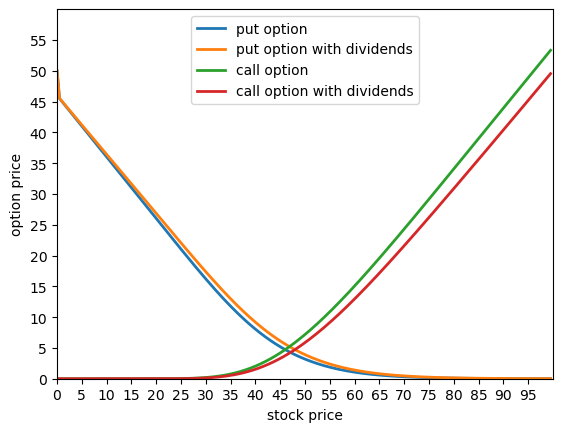

In [6]:
def european_put_implicit_q(r,sigma,S_0,K,T,M,N,q): #r:期望收益率 sigma:波动率 S_0:股票价格 M:纵向划分 N:横向划分 q:股利收益率
    dS=3*S_0/M
    dt=T/N
    
    a=lambda j: 0.5*(r-q)*j*dt-0.5*sigma*sigma*j*j*dt
    b=lambda j: 1+sigma*sigma*j*j*dt+r*dt
    c=lambda j: -0.5*(r-q)*j*dt-0.5*sigma*sigma*j*j*dt
    
    f1=[max(K-i*dS,0) for i in range(M+1)]
    f2=[None for i in range(M+1)]
     
    #构建系数矩阵
    coef=np.zeros((M-1,M-1))
    coef[0][0]=b(1) #j=1的边界条件，因为f(N-1,0)=K
    coef[0][1]=c(1)
    coef[M-2][M-3]=a(M-1) #j=M-1的边界条件，上边界
    coef[M-2][M-2]=b(M-1)
    for j in range(2,M-1):
        coef[j-1][j-2]=a(j)
        coef[j-1][j-1]=b(j)
        coef[j-1][j]=c(j)
        
    for i in range(N-1,-1,-1):
        f2=list(f1) #迭代从右边界出发
        coef_inv=np.linalg.inv(coef)
        F2=f2[1:-1] #切取j=1,...,M-1
        F2[0]-=K*a(1) #调整第一个方程的RHS
        F1=solve_tri(coef, F2)
        f1[1:M]=F1
        f1[0]=K
        f1[M]=0
    ini=int(S_0/dS)
    put_price=f1[ini]
    price_list_S=[]
    for i in range(M+1):
        price_list_S.append(f1[i])
    price_list_S=price_list_S[0:2*ini]
    index_list=[dS*i for i in range(2*ini)]
    return put_price,price_list_S,index_list


put_price_q,list_S_q,index_list_q=european_put_implicit_q(r,sigma,S_0,K,T,M,N,q)

def european_call_implicit_q(r,sigma,S_0,K,T,M,N,q): #r:期望收益率 sigma:波动率 S_0:股票价格 M:纵向划分 N:横向划分
    dS=3*S_0/M
    dt=T/N
    
    a=lambda j: 0.5*(r-q)*j*dt-0.5*sigma*sigma*j*j*dt
    b=lambda j: 1+sigma*sigma*j*j*dt+r*dt
    c=lambda j: -0.5*(r-q)*j*dt-0.5*sigma*sigma*j*j*dt
    
        
    f1=[max(i*dS-K,0) for i in range(M+1)] #call 与 put 的区别是边界条件不同
    f2=[None for i in range(M+1)]
    #构建系数矩阵
    coef=np.zeros((M-1,M-1))   
    coef[0][0]=b(1) #j=1的边界条件，因为f(N-1,0)=0
    coef[0][1]=c(1)
    coef[M-2][M-3]=a(M-1) #j=M-1的边界条件，上边界
    coef[M-2][M-2]=b(M-1)
    for j in range(2,M-1):
        coef[j-1][j-2]=a(j)
        coef[j-1][j-1]=b(j)
        coef[j-1][j]=c(j)
        
    for i in range(N-1,-1,-1):
        f2=list(f1) #迭代从右边界出发
        F2=f2[1:-1] #切取j=1,...,M-1
        F2[M-2]-=(dS*M-K)*c(M-1) #调整第M-1个方程的RHS ;上边界条件 S_0*3-k
        
        F1=solve_tri(coef, F2)
        
        f1[1:M]=F1
        f1[0]=0
        f1[M]=dS*M
    price_list_S=[]
    for i in range(M+1):
        price_list_S.append(f1[i])
    ini=int(S_0/dS)
    call_price=f1[ini]
    price_list_S=price_list_S[0:2*ini]
    index_list=[dS*i for i in range(2*ini)]
    return call_price,price_list_S, index_list


call_price_q,clist_S_q,cindex_list_q=european_call_implicit_q(r,sigma,S_0,K,T,M,N,q)

# plot
fig, ax = plt.subplots()

ax.plot(np.array(index_list),np.array(list_S), linewidth=2.0, label='put option')
ax.plot(np.array(index_list_q),np.array(list_S_q), linewidth=2.0, label='put option with dividends')

ax.plot(np.array(cindex_list),np.array(clist_S), linewidth=2.0, label='call option')
ax.plot(np.array(cindex_list_q),np.array(clist_S_q), linewidth=2.0, label='call option with dividends')
ax.set(xlim=(0,100), xticks=np.arange(0, 100,5),xlabel="stock price",
       ylim=(0, 60), yticks=np.arange(0, 60,5),ylabel="option price")
ax.legend()
plt.show()